# Explore Categorical Variables to Classify Company Status

In [4]:
from modules import *

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

In [17]:
#read in the data from data prep notebook
data = pd.read_hdf('results/classification_data.h5', 'classification_data')
data.head()

closed     status          name     category_code had_funding  \
7      No  operating  Fundable.com           finance          No   
8      No  operating         Wevod       games_video         Yes   
11     No   acquired       Jumptap            mobile         Yes   
18    Yes     closed  FairSoftware               web         Yes   
22     No  operating           WPP  public_relations          No   

    num_investment  num_relationships  num_milestones  logo_height  \
7              3.0                3.0             4.0        120.0   
8              0.0                2.0             0.0         89.0   
11             0.0               45.0             3.0        165.0   
18             0.0                1.0             1.0         67.0   
22            21.0               23.0             3.0         59.0   

    logo_width    region degree_type             institution  \
7        120.0  Columbus         BBA   Ohio State University   
8        250.0     Paris          MS                 EPITECH   
11       650.0    Boston          BA     American University   
18       250.0    SF Bay          MS                 Supelec   
22        86.0  New York      Degree  University of Kentucky   

                               subject              birthplace first_name  \
7          Entrepreneurship, Marketing                    Ohio       Eric   
8   computer sciences and technologies                  France     Nassim   
11                           Economics  St. Petersburg, Russia   Veronika   
18              Electrical Engineering           Paris, France      Alain   
22                              Degree                Kentucky       Jack   

   last_name  
7       Corl  
8   Ghandour  
11    Sonsev  
18   Raynaud  
22     Smith

Let's examine the data a bit, first the frequency of our response variable.

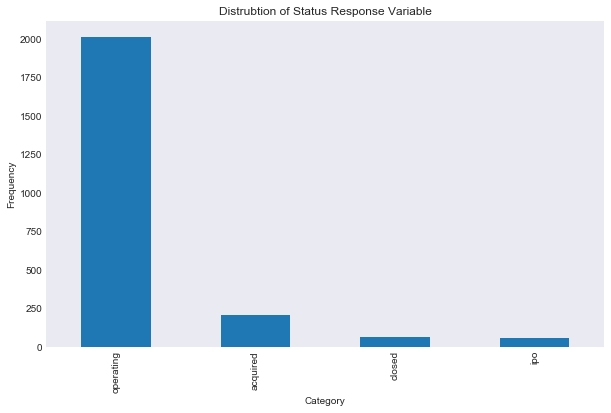

In [7]:
#frequencies of status variables
data['status'].value_counts().plot(kind = 'bar')
plt.title('Distrubtion of Status Response Variable')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.savefig("results/classification_status_variable_dist.png")

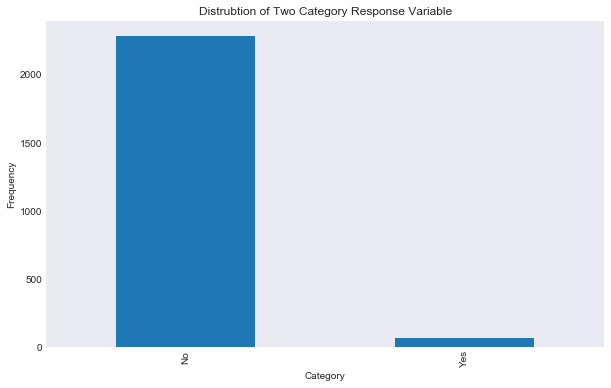

In [8]:
#frequncies of closed varible
data['closed'].value_counts().plot(kind = 'bar')
plt.title('Distrubtion of Two Category Response Variable')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.savefig("results/classification_closed_variable_dist.png")

As you can see the vast majority of the data represents companies that are still operating. I am going to start with the easier two class response closed vs not closed, and then move on to the company status. The issue that we have here, and one that we need to keep in mind for our classification models, is that we have a huge difference in our response variable prior probabilities. The issue may arrive when evaluated performance, here is an example of why this may be an issue. Say we are modeling a rare disease where 99.99 percent of our data does not have the disease and 0.01 percent of our data does have the disease. Then a model that just predicts "no" every time has an error rate of 0.0001, which is very low, but our model obviously sucks.

## Random Forest Classifier

I am going to start by using a random forest to classify status of a company. The reason I am going to focus on random forests is that random forests allow us to view the variable importance very easily, allowing us to see what predictors are most impactful in company status. Another reason random forests are nice in this case is that the sklearn RandomForestClassifier allows me to weight the response categories by setting class_weight, reducing the issue I discussed before of unbalanced prior probabilities. I also just want to try out sklearn's random forest classifier and compare it to the r package randomForest.

I did not realize sklearn's random forest method does not except categorical variables yet. So I'm going to have to convert a bunch of variables into dumby variables. I don't really like this, as an example why, say my 3 levels of a category are 'green', 'red', and 'blue' and an encoder make green = 0, red = 1, blue = 2. Then by this classification red is "in between" green and blue, when this is not the case. However, the alternative is create dumby columns for each category of each variable, and that would create a huge number of predictors, so for now I am going to go with the more naive approach.

In [9]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [15]:
#function to transform to encoded numerical variables
def transform_dumby(df, preds_index):
    """
    Description: transform a data predictors into dumby variables
    
    inputs:
        df: pandas data frame
        preds_index: preds_index: eiter an a two item list consisting of the start and stop column index or tuple of predictors column index or a single integer. If it is a single integer we assume this is the first index and predictors are the rest of the df.
    
    out: pandas df with encoded variables
    """
    rt_df = df.copy()
    
    if not isinstance(preds_index, int):
        start = preds_index[0]
        stop = preds_index[1]
        
        predictor_list = df.columns.values[start:stop]
    else:
        predictor_list = df.columns.values[preds_index:]
        
    for col_name in predictor_list:
        col = df[col_name]
        if not np.issubdtype(col.dtype, np.number):
            label_encoder = preprocessing.LabelEncoder()
            label_encoder.fit(col)
            new_col = label_encoder.transform(col)
            rt_df[col_name] = new_col
    return(rt_df)

In [18]:
#transform the data so random forest can use it
dat = transform_dumby(data, 3)
dat.head()

closed     status          name  category_code  had_funding  \
7      No  operating  Fundable.com             11            0   
8      No  operating         Wevod             12            1   
11     No   acquired       Jumptap             22            1   
18    Yes     closed  FairSoftware             40            1   
22     No  operating           WPP             30            0   

    num_investment  num_relationships  num_milestones  logo_height  \
7              3.0                3.0             4.0        120.0   
8              0.0                2.0             0.0         89.0   
11             0.0               45.0             3.0        165.0   
18             0.0                1.0             1.0         67.0   
22            21.0               23.0             3.0         59.0   

    logo_width  region  degree_type  institution  subject  birthplace  \
7        120.0     110           69          701      465         745   
8        250.0     336          317          273     1116         330   
11       650.0      57           52           26      352         980   
18       250.0     372          317          894      394         790   
22        86.0     309          199         1182      310         492   

    first_name  last_name  
7          344        366  
8          797        634  
11        1147       1748  
18          29       1508  
22         507       1731

Now I need to split into test and training sets. One common convention is to use 80 percent of the data as the training set.

In [9]:
#shape of the data
dat.shape

(2348, 17)

In [10]:
import random
#split into test and training set using 80 percent of the data
training = dat.sample(frac = 0.8, random_state = 1)
training.shape

(1878, 17)

In [11]:
#get test data being removing the training rows from data
training_index = list(training.index)

test = dat.drop(training_index, axis = 0)
test.shape

(470, 17)

Now I can seperate the predictors and response variables in the training and test data.

In [22]:
#function to seperate predictors and response in one line
def seperate_preds_response(df, response_var, preds_index):
    """
    decription: function that makes it so I don't have to split into predictors and response for test and traiing data.
    
    inputs:
        df: training or test data frame
        response_var: either a string of the name of the response variable or a list of strings for multiple different response variables
        preds_index: eiter an a two item list consisting of the start and stop column index or tuple of predictors column index or a single integer. If it is a single integer we assume this is the first index and predictors are the rest of the df.
    output:
        List of predictors and response. 
        First item of the list is the data frame of predictors. The rest are the response series.
    """
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError("df must be Pandas DFs")
        
    dfs = []
    
    if not isinstance(preds_index, int):
        start = preds_index[0]
        stop = preds_index[1]
        
        predictor_list = df.columns.values[start:stop]
    else:
        predictor_list = df.columns.values[preds_index:]
        
    predictors = df[predictor_list] 
    
    dfs.append(predictors)
    
    for var in response_var:
        if not isinstance(var, str):
            raise TypeError("columns of response_var must be strings in the data frame")
            
        resp = df[var]
        dfs.append(resp)
        
    return(dfs)

In [13]:
#seperate predictors and response
train_preds, train_closed, train_status = seperate_preds_response(training, ['closed', 'status'], 3)

test_preds, test_closed, test_status = seperate_preds_response(test, ['closed', 'status'], 3)

In [14]:
#training shape
train_preds.shape

(1878, 14)

In [15]:
#test shape
test_preds.shape

(470, 14)

I am now going to fit a random forest classifier on the status of the data.

In [16]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

In [17]:
from sklearn.model_selection import GridSearchCV

Before I fit the random forest model I am going to use GridSearchCV to perform cross validation in order to tune the hyperparameters of the random forest. In the case of this random forest I am going to tune the number of trees in the random forest 'n_estimators', the parameter 'max_features', and the maximum depth (terminal nodes) of the tree 'max_depth'. The 'max_features' parameter is the most important parameter for random forests, and determines the maximum number of predictors to random forest will look at when decided how to best split the data. The reason random forests do not look at all of the predictors in the data when creating splits lies in the bias-variance trade off: the random forest will risk increasing bias while reducing variance in limiting the maximum number of features. This reduces any error causes my highly correlated predictors.

Cross Validation allows us to tune these hyperparameters. When looking at the predictive power of a learning model, the accuracy of the model in predicting the data used to train it is a dis-honest evaluation of the model. Cross Validation splits the data in k folds, then for each value of the hyperparameters we are looking at it training the model on all but one of the folds at a time, tests the model on each left out fold. The average perforamnce of each of the k folds is used as the estimated performance of the hyperparameters. Using GridSearchCV I can find the best combination of my two hyperparameters. 

In [67]:
#list of number of predictors examined in the CV
num_preds = np.arange(2, np.ceil(train_preds.shape[1] / 2)).astype(int)

#list of the number of trees used in the CV
n_ests = [50, 100, 150, 200, 250]

#max depth
m_depth = np.arange(1, 11)

The cell below may take a view minutes to run. As side note, while this next cell does take a but of time to run, if we run to do the same in r it would take much longer. GridSearchCV is one of the most usefull parts of sklearn in my limited experience with it.

In [69]:
#dictionary of parameters to be tuned
params = {'max_features':  num_preds, 'max_depth': m_depth, 'n_estimators': n_ests}

#intialize a random forest classifier.
#random state sets the random set of the classifier
#class_weight = 'balanced_subsample'
rcf = RandomForestClassifier(random_state = 100, class_weight = 'balanced')

#do 5-fold cross validation the hyperparameters
cv_rcf = GridSearchCV(rcf, params, cv = 5, scoring = 'accuracy', return_train_score = False)

#fit the training data
cv_rcf.fit(train_preds, train_status)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([2, 3, 4, 5, 6]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'n_estimators': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [70]:
#look at results of the cross validation
cv_results = pd.DataFrame(cv_rcf.cv_results_)
cv_results.head()

mean_fit_time  mean_score_time  mean_test_score param_max_depth  \
0       0.088150         0.006749         0.586794               1   
1       0.172873         0.013270         0.573482               1   
2       0.275759         0.020571         0.588924               1   
3       0.422137         0.024663         0.604366               1   
4       0.448911         0.030756         0.603301               1   

  param_max_features param_n_estimators  \
0                  2                 50   
1                  2                100   
2                  2                150   
3                  2                200   
4                  2                250   

                                              params  rank_test_score  \
0  {'max_depth': 1, 'max_features': 2, 'n_estimat...              206   
1  {'max_depth': 1, 'max_features': 2, 'n_estimat...              224   
2  {'max_depth': 1, 'max_features': 2, 'n_estimat...              203   
3  {'max_depth': 1, 'max_features': 2, 'n_estimat...              185   
4  {'max_depth': 1, 'max_features': 2, 'n_estimat...              187   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.623342           0.598404           0.529255           0.610667   
1           0.652520           0.579787           0.513298           0.576000   
2           0.644562           0.614362           0.529255           0.581333   
3           0.660477           0.617021           0.561170           0.597333   
4           0.644562           0.627660           0.558511           0.605333   

   split4_test_score  std_fit_time  std_score_time  std_test_score  
0           0.572193      0.021638        0.002060        0.033380  
1           0.545455      0.016911        0.002623        0.046313  
2           0.574866      0.035714        0.004248        0.038919  
3           0.585561      0.055265        0.002816        0.033436  
4           0.580214      0.015323        0.006360        0.031132

In [71]:
#data frame of variables to examine
scores = cv_results[['mean_test_score', 'param_max_features', 'param_n_estimators', 'param_max_depth']]

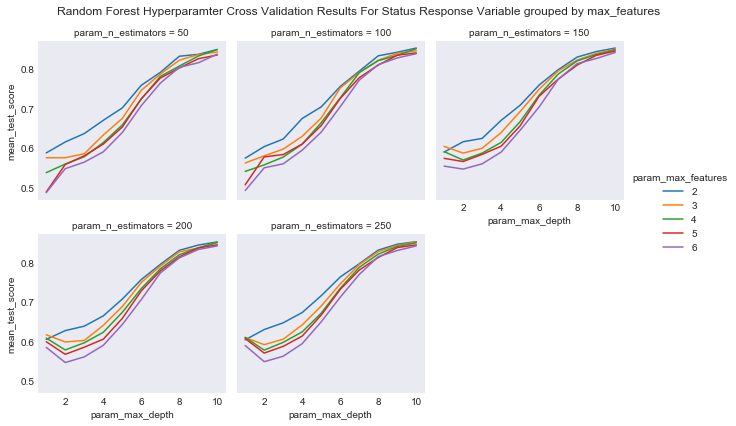

In [113]:
#plot the results of the cross validation grouped by max_features and faceted by number of trees
p = sns.FacetGrid(data = cv_results, col = 'param_n_estimators',
                  hue = 'param_max_features', col_wrap=3)
p.map(plt.plot, 'param_max_depth', 'mean_test_score').add_legend()
plt.suptitle("Random Forest Hyperparamter Cross Validation Results For Status Response Variable grouped by max_features")
p.fig.subplots_adjust(top=0.9)
plt.savefig("results/rf_cv_results_status_max_features")

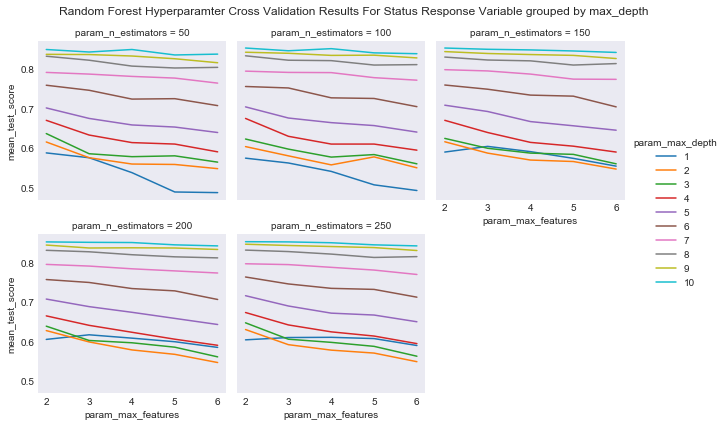

In [112]:
#plot the results of the cross validation grouped by max_depth and faceted by number of trees
p = sns.FacetGrid(data = cv_results, col = 'param_n_estimators',
                  hue = 'param_max_depth', col_wrap=3)
p.map(plt.plot, 'param_max_features', 'mean_test_score').add_legend()
plt.suptitle("Random Forest Hyperparamter Cross Validation Results For Status Response Variable grouped by max_depth")
p.fig.subplots_adjust(top=0.9)
plt.savefig("results/rf_cv_results_status_max_depth.png")

I can now fit a random forest using the best combination of hyperparameters.

In [74]:
#fit the best cross validation random forest
best_rcf = cv_rcf.best_estimator_
best_rcf.fit(train_preds, train_status)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=2,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

Now I can look at the feature importance of each variable. This is the variable that best splits the data into the status categories.

In [75]:
#create data frame of variable importance
d = {'variable': train_preds.columns.values, 'gini': best_rcf.feature_importances_}
feature_imp = pd.DataFrame(d)
feature_imp

gini           variable
0   0.063953      category_code
1   0.040659        had_funding
2   0.049590     num_investment
3   0.157286  num_relationships
4   0.073591     num_milestones
5   0.081227        logo_height
6   0.081458         logo_width
7   0.058427             region
8   0.047667        degree_type
9   0.069987        institution
10  0.062029            subject
11  0.069890         birthplace
12  0.072208         first_name
13  0.072028          last_name

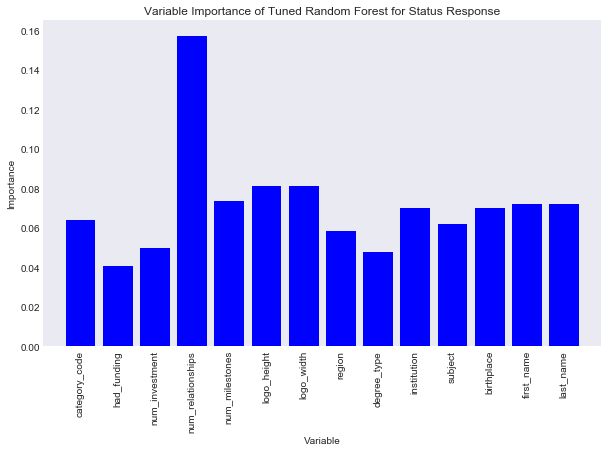

In [111]:
#plot variable importance
imps = best_rcf.feature_importances_
x = range(train_preds.shape[1])
feature_names = train_preds.columns

f, ax = plt.subplots()
plt.bar(x, imps, color = 'b', align = 'center')
plt.xticks(x, feature_names, rotation='vertical')
plt.xlim(-1, train_preds.shape[1])
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("Variable Importance of Tuned Random Forest for Status Response")
plt.savefig("results/variable_importance_status_random_forest.png")

It seems num_relationships best splits our data into the status categories.

Now I am going to move on to testing. Recall before I mentioned how the issue of class imbalance may effect our learning model. While we were able to find out number of relationships split the data well the status category, we still don't know how well that model predicts unseen data? First let's look at the accuracy of our model.

In [77]:
#look at accuracy of the data
test_status_score = best_rcf.score(test_preds, test_status)
test_status_score

0.85744680851063826

That's not horrible. However, I mentioned before the issue when attempting to classify on a data set with highly unbalanced accuracy is that a model can return "accurate" results by simply classifying every observation as the class with the overwhelmingly high frequency. Below I will show the confusion matrix of the predictions our model made. In a confusion matrix, the number in the ith row and jth column is the number of individuals we predicted to be in the "ith" class, but is really in the "jth" class, based on some ordering. I provide the ordering in a list before the confusion matrix is printed.

In [80]:
from sklearn.metrics import confusion_matrix
#class predictions
preds_status_forest = best_rcf.predict(test_preds)
#confusion matrix
labs = list(set(test_status))
print(labs)
cf = confusion_matrix(test_status, preds_status_forest, labels = labs)
print(cf)

['closed', 'operating', 'acquired', 'ipo']
[[  0  13   1   0]
 [  0 401   3   3]
 [  0  35   0   0]
 [  0  12   0   2]]


As you can see, the model did not do very well. Very few cases in the test sample were predicted to be not 'operating', showing the model really is not predicting anything. I thought that possibilty changing the scoring attribute of GridSearchCV to something based on an f1 score or precesion could help, however, in general it didn't. Based on what I found online, it turns out sklearn is still not so great with really inbalanced data sets like the one I am working with. In theory, I could have used an f1 score, however, that still wasn't working once a fit the data. I saw some pretty heated people talking on stack overflow about this issue, and it seemed even the class_weight attribute could not help me here. Basically, because sklearn's fit method optimized by accuracy. I was unable to find a solution to this. 

However, one thing I can do is switch to binary variables and fit my models hyper-parameters using the sklearn's roc_auc_score to measure test performance via auc. A receiver operating characteristic curve (ROC curve) is a good way to measure predictive performance of a two class response variable. AUC, short for area under the curve, provides a performance metric for a predictive model by calculating the area under the ROC curve.

### Closed

First, I realized that sklearn prefers binary 1 or 0 encoding for categorical responses in order to find the ROC curve and AUC so I am going to switch the encoding. Then I will run the sam process as before, but this time on the binary variable indicating whether a business was closed or not.

In [81]:
#change encoding
train_closed_binary = [1 if v == 'Yes' else 0 for v in train_closed]

Note: the below cell may take a while

In [22]:
#make closed model
#params = {'max_features':  num_preds, 'n_estimators': n_ests}
params = {'max_features':  num_preds, 'max_depth': m_depth, 'n_estimators': n_ests}

rcf_closed = RandomForestClassifier(random_state = 100, class_weight = 'balanced')

cv_rcf_closed = GridSearchCV(rcf_closed, params, cv = 5, scoring = 'roc_auc',
                      return_train_score = False)

#cv_rcf.fit(train_preds, train_closed)
cv_rcf_closed.fit(train_preds, train_closed_binary)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([2, 3, 4, 5, 6]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'n_estimators': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

In [82]:
#get scores
scores_closed = pd.DataFrame(cv_rcf_closed.cv_results_)
cv_results_closed = scores_closed[['mean_test_score', 'param_max_features', 'param_max_depth', 'param_n_estimators']]

In [29]:
#cv_results_closed_melt = cv_results_closed.melt(['param_max_features', 'param_max_depth', 'mean_test_score'])
#cv_results_closed_melt.head()

param_max_features param_max_depth  mean_test_score            variable  \
0                  2               1         0.749251  param_n_estimators   
1                  2               1         0.757797  param_n_estimators   
2                  2               1         0.757466  param_n_estimators   
3                  2               1         0.758462  param_n_estimators   
4                  2               1         0.761374  param_n_estimators   

  value  
0    50  
1   100  
2   150  
3   200  
4   250

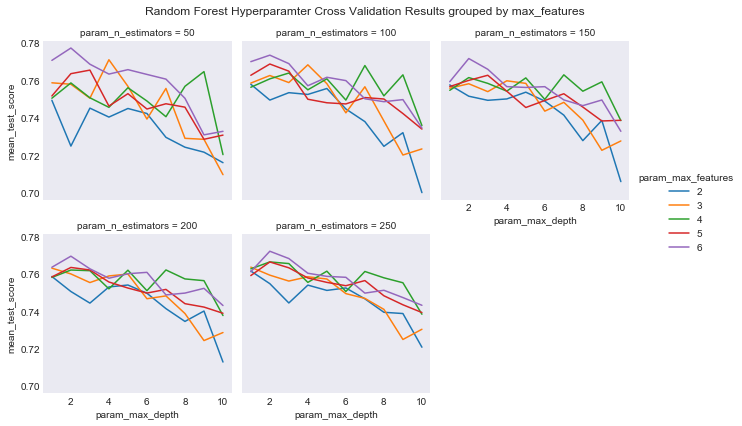

In [109]:
#plot cross validation results
p = sns.FacetGrid(data = cv_results_closed, col = 'param_n_estimators',
                  hue = 'param_max_features', col_wrap=3)
p.map(plt.plot, 'param_max_depth', 'mean_test_score').add_legend()
plt.suptitle("Random Forest Hyperparamter Cross Validation Results grouped by max_features")
p.fig.subplots_adjust(top=0.9)
plt.savefig('results/rf_closed_cv_results_max_features')

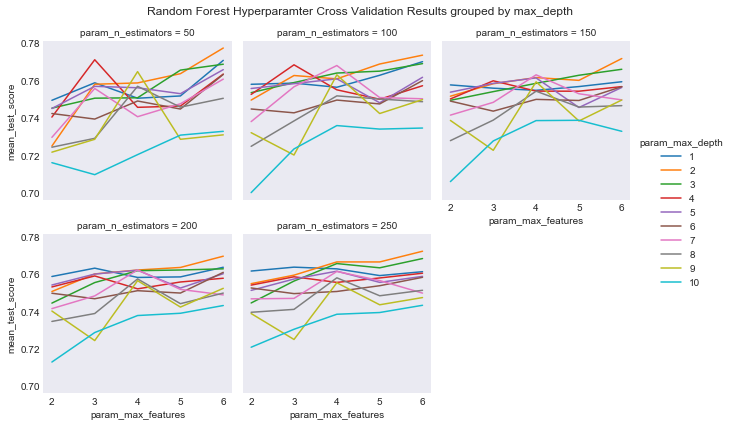

In [108]:
#plot cross validation results
p = sns.FacetGrid(data = cv_results_closed, col = 'param_n_estimators',
                  hue = 'param_max_depth', col_wrap=3)
p.map(plt.plot, 'param_max_features', 'mean_test_score').add_legend()
plt.suptitle("Random Forest Hyperparamter Cross Validation Results grouped by max_depth")
p.fig.subplots_adjust(top=0.9)
plt.savefig('results/rf_closed_cv_results_max_depth')

In [85]:
#fit the best model based on the best hyperparameters
best_rcf_closed = cv_rcf_closed.best_estimator_
best_rcf_closed.fit(train_preds, train_closed_binary)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features=6,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

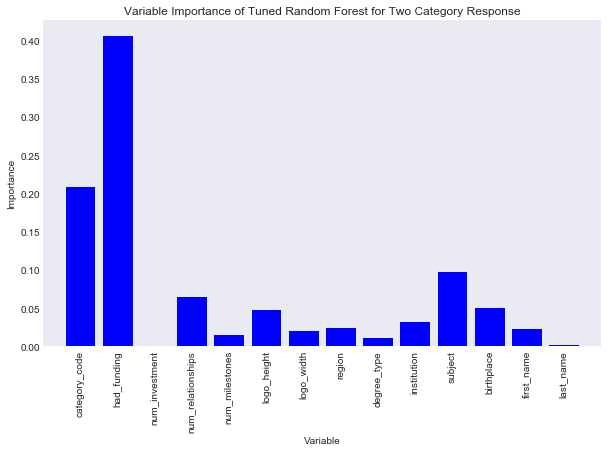

In [98]:
#look at variable importance
d = {'variable': train_preds.columns.values, 'gini': best_rcf_closed.feature_importances_}
feature_imp_closed = pd.DataFrame(d)
imps_closed = best_rcf_closed.feature_importances_
x = range(train_preds.shape[1])
feature_names = train_preds.columns

f, ax = plt.subplots()
plt.bar(x, imps_closed, color = 'b', align = 'center')
plt.xticks(x, feature_names, rotation='vertical')
plt.xlim(-1, train_preds.shape[1])
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("Variable Importance of Tuned Random Forest for Two Category Response")
plt.savefig("results/random_forest_two_class_variable_importance.png")

Now it seems the feature that is the most important is had_funding, followed by category_code. The number of investments is suprisingly low, however last name of founder is also very low in importance for determining the status of a company, which is expected. One other thing I notice, school subject of a founder is more important than the institution of a founder, which is more important than the degree type.

Now we can look at the test performance of our new random forest model. Let's start with accuracy.

In [89]:
#encode test response variibale
test_closed_binary = [1 if v == 'Yes' else 0 for v in test_closed]
#look at test score
best_rcf_closed.score(test_preds, test_closed_binary)

0.7191489361702128

This is low, much lower than the test score we got for our previous random forest. However, the issue there was that the model had no true predictive power.

In [91]:
#look at test confusion matrix
preds_closed_forest = best_rcf_closed.predict(test_preds)
#confusion matrix
labs = list(set(test_closed_binary))
print(labs)
cf_closed = confusion_matrix(y_true = test_closed_binary, y_pred = preds_closed_forest, labels = labs)
print(cf_closed)

[0, 1]
[[327 129]
 [  3  11]]


Now you can see that the model is actually predicting negative cases. In the model on status we were constantly predicting a business would be operating, and were rarely able to predict when a business would have any other status. In this case, we were able to predict almost all of the closed businesses, even though we predicted many operating business would be closed.

The issue now with the model is the high false positve rates, but in the data sets like the one we are working with, this example becomes a lot like attempting to predict a rare disease. When predicting a rare disease, obviously having too high of a false positive rate is much prefferable to a high false negative rate. While originally we set out to attempt find out how to predict succes, I'm actually now kind of trying to find how to predict failure.

Remember I picked the hyperparameters of this model based on the AUC score, so let's look at our model performance bu looking at the ROC curve and AUC statistic.

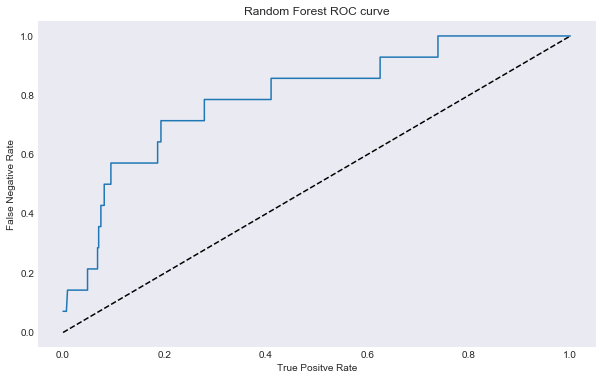

In [97]:
from sklearn.metrics import roc_curve
pred_probs_closed_pos = best_rcf_closed.predict_proba(test_preds)[:,1]
fpr, tpr, thresholds = roc_curve(test_closed_binary, pred_probs_closed_pos)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title("Random Forest ROC curve")
plt.xlabel("True Positve Rate")
plt.ylabel("False Negative Rate")
plt.savefig('results/random_forest_roc_curve.png')

In [93]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_closed_binary, pred_probs_closed_pos)

0.79456453634085211

Once again our performance isn't great. If we wanted great performance we could have turned every feature into a dumby indicator variable and run a KNN model, however, then we would not have any good inference on important features, and would have run the risk of overfitting the data. 

## Extra Trees Classifier

In [19]:
data.head()

closed     status          name     category_code had_funding  \
7      No  operating  Fundable.com           finance          No   
8      No  operating         Wevod       games_video         Yes   
11     No   acquired       Jumptap            mobile         Yes   
18    Yes     closed  FairSoftware               web         Yes   
22     No  operating           WPP  public_relations          No   

    num_investment  num_relationships  num_milestones  logo_height  \
7              3.0                3.0             4.0        120.0   
8              0.0                2.0             0.0         89.0   
11             0.0               45.0             3.0        165.0   
18             0.0                1.0             1.0         67.0   
22            21.0               23.0             3.0         59.0   

    logo_width    region degree_type             institution  \
7        120.0  Columbus         BBA   Ohio State University   
8        250.0     Paris          MS                 EPITECH   
11       650.0    Boston          BA     American University   
18       250.0    SF Bay          MS                 Supelec   
22        86.0  New York      Degree  University of Kentucky   

                               subject              birthplace first_name  \
7          Entrepreneurship, Marketing                    Ohio       Eric   
8   computer sciences and technologies                  France     Nassim   
11                           Economics  St. Petersburg, Russia   Veronika   
18              Electrical Engineering           Paris, France      Alain   
22                              Degree                Kentucky       Jack   

   last_name  
7       Corl  
8   Ghandour  
11    Sonsev  
18   Raynaud  
22     Smith

## Using dumby

In [20]:
data.head()

closed     status          name     category_code had_funding  \
7      No  operating  Fundable.com           finance          No   
8      No  operating         Wevod       games_video         Yes   
11     No   acquired       Jumptap            mobile         Yes   
18    Yes     closed  FairSoftware               web         Yes   
22     No  operating           WPP  public_relations          No   

    num_investment  num_relationships  num_milestones  logo_height  \
7              3.0                3.0             4.0        120.0   
8              0.0                2.0             0.0         89.0   
11             0.0               45.0             3.0        165.0   
18             0.0                1.0             1.0         67.0   
22            21.0               23.0             3.0         59.0   

    logo_width    region degree_type             institution  \
7        120.0  Columbus         BBA   Ohio State University   
8        250.0     Paris          MS                 EPITECH   
11       650.0    Boston          BA     American University   
18       250.0    SF Bay          MS                 Supelec   
22        86.0  New York      Degree  University of Kentucky   

                               subject              birthplace first_name  \
7          Entrepreneurship, Marketing                    Ohio       Eric   
8   computer sciences and technologies                  France     Nassim   
11                           Economics  St. Petersburg, Russia   Veronika   
18              Electrical Engineering           Paris, France      Alain   
22                              Degree                Kentucky       Jack   

   last_name  
7       Corl  
8   Ghandour  
11    Sonsev  
18   Raynaud  
22     Smith

In [23]:
start_preds, long_closed, long_status = seperate_preds_response(data, ['closed', 'status'], 3)

In [25]:
long_preds = pd.get_dummies(start_preds)
long_preds.head()

num_investment  num_relationships  num_milestones  logo_height  \
7              3.0                3.0             4.0        120.0   
8              0.0                2.0             0.0         89.0   
11             0.0               45.0             3.0        165.0   
18             0.0                1.0             1.0         67.0   
22            21.0               23.0             3.0         59.0   

    logo_width  category_code_advertising  category_code_analytics  \
7        120.0                          0                        0   
8        250.0                          0                        0   
11       650.0                          0                        0   
18       250.0                          0                        0   
22        86.0                          0                        0   

    category_code_automotive  category_code_biotech  category_code_cleantech  \
7                          0                      0                        0   
8                          0                      0                        0   
11                         0                      0                        0   
18                         0                      0                        0   
22                         0                      0                        0   

              ...              last_name_paunikar  last_name_raj  \
7             ...                               0              0   
8             ...                               0              0   
11            ...                               0              0   
18            ...                               0              0   
22            ...                               0              0   

    last_name_rokade  last_name_seo  last_name_sk  last_name_termini  \
7                  0              0             0                  0   
8                  0              0             0                  0   
11                 0              0             0                  0   
18                 0              0             0                  0   
22                 0              0             0                  0   

    last_name_van Apeldoorn  last_name_van Loo  last_name_van der Chijs  \
7                         0                  0                        0   
8                         0                  0                        0   
11                        0                  0                        0   
18                        0                  0                        0   
22                        0                  0                        0   

    last_name_von Wallenstein  
7                           0  
8                           0  
11                          0  
18                          0  
22                          0  

[5 rows x 7996 columns]

In [ ]:
num_preds = np.arange(2, np.ceil(np.sqrt(long_preds.shape[1])) + 1, step = ).astype(int)

In [ ]:
params = {'max_features':  num_preds, 'n_estimators': n_ests}
rcf_long = RandomForestClassifier(random_state = 100,
                             class_weight = 'balanced')
cv_rcf_long = GridSearchCV(rcf_long, params, cv = 5, scoring = 'accuracy',
                      return_train_score = False)

cv_rcf_long.fit(long_preds, long_status)

In [ ]:
scores = [x[1] for x in cv_rcf_long.grid_scores_]
scores = pd.DataFrame(cv_rcf_long.cv_results_)
scores